- 지난 결과를 보완하여  
focal의 gamma와 alpha를 조금 바꿔서 -> gamma3.0, alpha0.25로 실험해보자.  

In [1]:
import os, random
import numpy as np
import tensorflow as tf

SEED=42
os.environ["PYTHONHASHSEED"]=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

gpus=tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

print("GPU 사용 가능 여부:", tf.config.list_physical_devices("GPU"))

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2025-06-13 16:02:48.435791: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-13 16:02:48.541303: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-13 16:02:48.541378: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-13 16:02:48.551462: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-13 16:02:48.591820: I tensorflow/core/platform/cpu_feature_guar

GPU 사용 가능 여부: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from tensorflow.keras import backend as K

def focal_loss(gamma=3.0, alpha=0.25):
    def loss(y_true, y_pred):
        epsilon=K.epsilon()
        y_pred=K.clip(y_pred, epsilon, 1.-epsilon)

        # binary cross-entropy 계산
        cross_entropy=-y_true*K.log(y_pred)-(1-y_true)*K.log(1-y_pred)

        # Focal weight 계산
        # y_true=1이면 (1 - y_pred)^gamma → 예측이 틀릴수록 가중치 증가
        # y_true=0이면 (y_pred)^gamma → 예측이 틀릴수록 가중치 증가
        weight=alpha*y_true*K.pow(1 - y_pred, gamma) + \
               (1 - alpha)*(1 - y_true)*K.pow(y_pred, gamma)

        return K.mean(weight * cross_entropy, axis=-1)
    return loss

In [3]:
IMG_SIZE=86
BATCH_SIZE=32
DATA_PATH="../../data/processed/02_kaggle_dataset/train"

datagen=ImageDataGenerator(
    rescale=1./255,
    brightness_range=[0.9, 1.1],
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode="nearest",
    horizontal_flip=False,
    validation_split=0.2
)

train_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training",
    shuffle=True,
    seed=SEED
)

val_generator=datagen.flow_from_directory(
    DATA_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation",
    shuffle=False,
    seed=SEED
)

Found 38400 images belonging to 2 classes.
Found 9600 images belonging to 2 classes.


In [ ]:
model=Sequential([
    Conv2D(64, 3, activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D(2),

    Conv2D(96, 3, activation="relu"),
    BatchNormalization(),
    MaxPooling2D(2),

    Flatten(),
    Dense(32, activation="relu", kernel_regularizer=l2(0.001)),
    Dropout(0.4),
    Dense(1, activation="sigmoid")
])

model.compile(optimizer=Adam(learning_rate=0.0005),
              loss=focal_loss(gamma=3.0, alpha=0.25),  # 값조정) 3.0, 0.25로 설정
              metrics=["accuracy"])

2025-06-13 16:03:00.538401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:03:00.538481: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:03:00.538516: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:03:00.709492: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-13 16:03:00.709586: I external/local_xla/xla/stream_executor

In [5]:
history=model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1)

Epoch 1/20


2025-06-13 16:03:04.003761: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-06-13 16:03:04.103659: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:225] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2025-06-13 16:03:04.103697: W external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:228] Used ptxas at ptxas
2025-06-13 16:03:04.103768: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-06-13 16:03:04.214201: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2025-06-13 16:03:04.662633: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kerne

1200/1200 [==============================] - 43s 33ms/step - loss: 0.1548 - accuracy: 0.7794 - val_loss: 1.3957 - val_accuracy: 0.6072
Epoch 2/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0357 - accuracy: 0.8546 - val_loss: 0.0265 - val_accuracy: 0.8944
Epoch 3/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0248 - accuracy: 0.8696 - val_loss: 0.0273 - val_accuracy: 0.8032
Epoch 4/20
1200/1200 [==============================] - 27s 22ms/step - loss: 0.0223 - accuracy: 0.8829 - val_loss: 0.0392 - val_accuracy: 0.7692
Epoch 5/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0204 - accuracy: 0.9126 - val_loss: 0.0224 - val_accuracy: 0.9246
Epoch 6/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0207 - accuracy: 0.9171 - val_loss: 0.1181 - val_accuracy: 0.5304
Epoch 7/20
1200/1200 [==============================] - 26s 22ms/step - loss: 0.0216 - accuracy: 0.9207 - val_loss: 0.0295 - val_accura

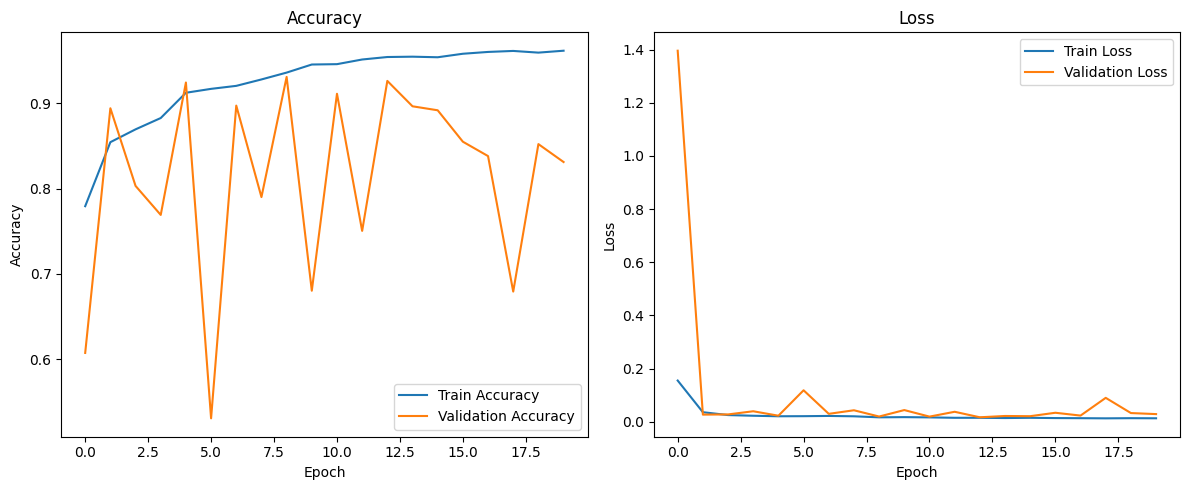

In [6]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig("../../results/images/02_focal_loss_training_plot(gamma3.0_alpha0.25).png")
plt.show()

              precision    recall  f1-score   support

      closed       0.75      1.00      0.86      4800
        open       1.00      0.67      0.80      4800

    accuracy                           0.84      9600
   macro avg       0.88      0.84      0.83      9600
weighted avg       0.88      0.84      0.83      9600



2025-06-13 16:14:41.405811: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13686349040843212458


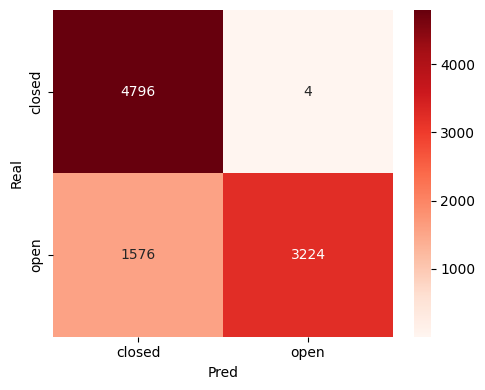

In [7]:
y_true=val_generator.classes
steps=val_generator.samples // val_generator.batch_size + 1
y_pred_prob=model.predict(val_generator, steps=steps, verbose=0)
y_pred=(y_pred_prob > 0.5).astype(int)

report=classification_report(y_true, y_pred, target_names=["closed", "open"])
print(report)

with open("../../results/reports/02_focal_loss_classification_report(gamma3.0_alpha0.25).txt", "w") as f:
    f.write(report)

conf_matrix=confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
            xticklabels=["closed", "open"], yticklabels=["closed", "open"])
plt.xlabel("Pred")
plt.ylabel("Real")
plt.tight_layout()
plt.savefig("../../results/images/02_focal_loss_confusion_matrix(gamma3.0_alpha0.25).png")
plt.show()

In [8]:
os.makedirs("../../src/models/06_focal_Model(gamma3.0_alpha0.25)", exist_ok=True)
model.save("../../src/models/06_focal_Model(gamma3.0_alpha0.25)/focal_model.keras")

Closed -> Open: 오분류 거의 없음 (4건) -> Focal loss로 완전히 잡힘  
Open -> Closed: 오분류 너무 많음 (1,576건) -> 부정확한 판별 증가  
Train vs Val Accuracy: 차이	꽤 큼 (96% vs 83%) -> 오버피팅 가능성  
Val accuracy: 변동성 매우 큼 일반화 부족 가능성  

여기서 가중치 실험을 더 하더라도 반대가 너무 떨어지게 된다.  
# 결론, 구조 튜닝 실험으로 전환한다.